In [217]:
# импорт библиотек
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

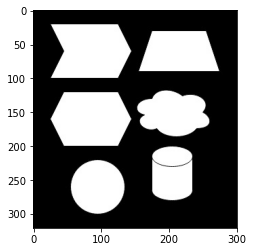

In [3]:
img = cv2.imread('img_in/basic_image.jpg', 1) # загрузка изображения
plt.imshow(img) # отображение 

In [28]:
def sp(img: np.ndarray, part: float)->np.ndarray:
    random_index = (np.random.rand(img.shape[0], img.shape[1])*100).astype(np.uint8) # генерируем случаный индексы
    output = np.copy(img) # делаем глубокую копию изображения
    output[random_index<=part] = 255 # заменяем значение пиксела
    return output

In [98]:
sp50 = sp(img, 50)

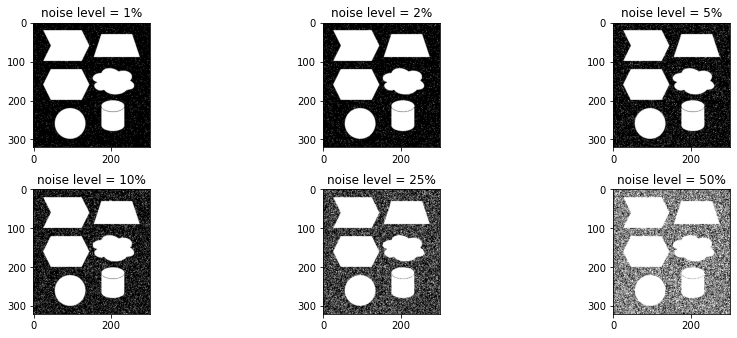

In [58]:
# Методика отображения взята из документации https://matplotlib.org/stable/gallery/lines_bars_and_markers/markevery_demo.html#sphx-glr-gallery-lines-bars-and-markers-markevery-demo-py
def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]
pie = [1, 2, 5, 10, 25, 50]
rows = len(pie)
cols = 3
axs = plt.figure(figsize=(12,12), constrained_layout=True).subplots(rows, cols)
axs = trim_axs(axs, rows)
for ax, part in zip(axs, pie):
    ax.set_title(f"noise level = {part}%")
    ax.imshow(sp(img, part))

In [273]:
def erosian(img: np.ndarray, kernal: np.ndarray) -> np.ndarray:
    x = kernal.shape[0] // 2
    y = kernal.shape[1] // 2
    output = img.copy()
    for i in range(y, img.shape[0] - y):
        for j in range(x, img.shape[1] - x):
            local_window = img[i-y:i+y+1, j-x:j+x+1]
            output[i][j] = np.min(local_window[kernal])
    return output

def dilate(img: np.ndarray, kernal: np.ndarray) -> np.ndarray:
    x, y = kernal.shape[0] // 2, kernal.shape[1] // 2
    output = img.copy()
    for i in range(y, img.shape[0] - y):
        for j in range(x, img.shape[1] - x):
            local_window = img[i-y:i+y+1, j-x:j+x+1]
            output[i][j] = np.max(local_window[kernal])
    return output

def opening(img: np.ndarray, kernal: np.ndarray) -> np.ndarray:
    temp = erosian(img, kernal)
    output = dilate(temp, kernal)
    return output

def closing(img: np.ndarray, kernal: np.ndarray) -> np.ndarray:
    temp = dilate(img, kernal)
    output = erosian(temp, kernal)
    return output

In [78]:
structs = {
    'cross3': np.array([[False,True,False],[True,True,True],[False,True,False]], dtype=bool),
    'rect3': np.ones((3,3), dtype=bool),
    'cross5': np.array([
        [False,False,True,False,False],
        [False,False,True,False,False],
        [True]*5,
        [False,False,True,False,False],
        [False,False,True,False,False]], dtype=bool),
    'rect5': np.ones((5,5), dtype=bool)
}

In [99]:
opers = {
    'erosian':[erosian(sp50,structs[kernel]) for kernel in structs],
    'dilate':[dilate(sp50,structs[kernel]) for kernel in structs],
    'opening':[opening(sp50,structs[kernel]) for kernel in structs],
    'close':[closing(sp50,structs[kernel]) for kernel in structs]
}

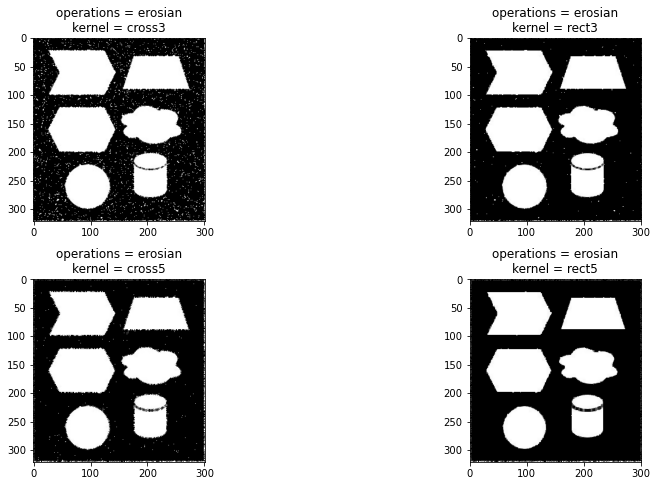

In [100]:
rows = 4
cols = 2
axs = plt.figure(figsize=(12,12), constrained_layout=True).subplots(rows, cols)
axs = trim_axs(axs, rows)
for ax, oper, kernel in zip(axs, opers['erosian'], structs):
    ax.set_title(f"operations = erosian\nkernel = {kernel}")
    ax.imshow(oper)

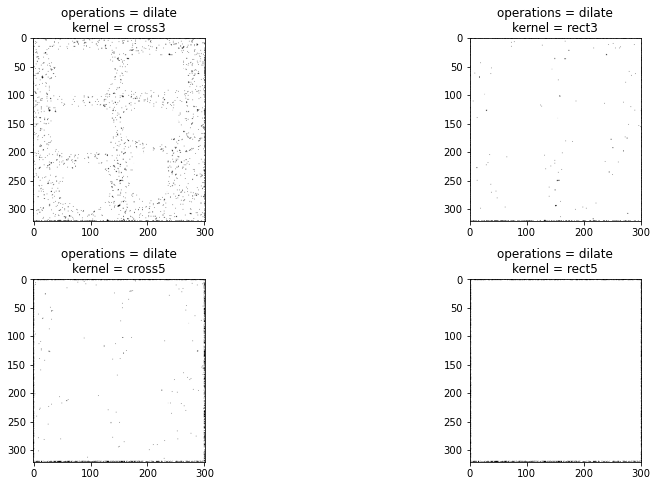

In [101]:
rows = 4
cols = 2
axs = plt.figure(figsize=(12,12), constrained_layout=True).subplots(rows, cols)
axs = trim_axs(axs, rows)
for ax, oper, kernel in zip(axs, opers['dilate'], structs):
    ax.set_title(f"operations = dilate\nkernel = {kernel}")
    ax.imshow(oper)

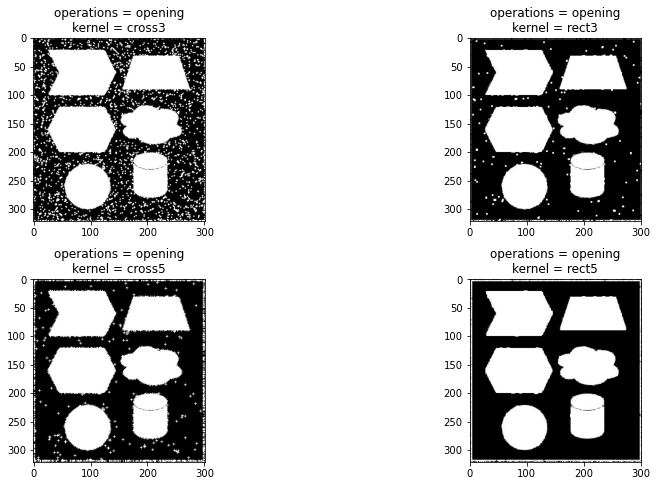

In [102]:
rows = 4
cols = 2
axs = plt.figure(figsize=(12,12), constrained_layout=True).subplots(rows, cols)
axs = trim_axs(axs, rows)
for ax, oper, kernel in zip(axs, opers['opening'], structs):
    ax.set_title(f"operations = opening\nkernel = {kernel}")
    ax.imshow(oper)

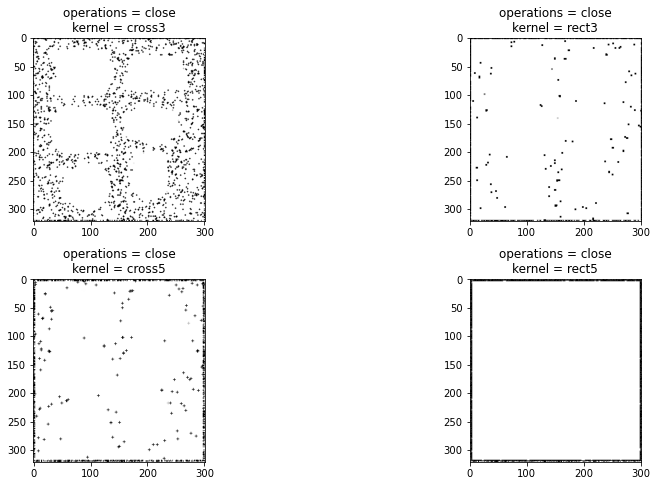

In [103]:
rows = 4
cols = 2
axs = plt.figure(figsize=(12,12), constrained_layout=True).subplots(rows, cols)
axs = trim_axs(axs, rows)
for ax, oper, kernel in zip(axs, opers['close'], structs):
    ax.set_title(f"operations = close\nkernel = {kernel}")
    ax.imshow(oper)

In [123]:
def tableFilter(img: np.ndarray, kernel: np.ndarray)->np.ndarray:
    x, y = kernel.shape[0] // 2, kernel.shape[1] // 2
    output = img.copy()
    for i in range(y, img.shape[0] - y):
        for j in range(x, img.shape[1] - x):
            local_window = img[i-y:i+y+1, j-x:j+x+1]
            temp = local_window[kernel]
            output[i][j] = np.max([temp[0],temp[1],temp[2],temp[3]]) if temp[2].all() else np.min([temp[0],temp[1],temp[2],temp[3]])
    return output

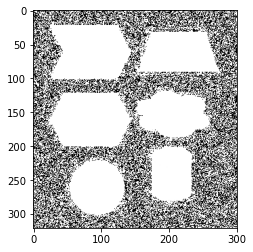

In [125]:
plt.imshow(tableFilter(sp50, structs['rect3']))

In [126]:
def custom_metric(img: np.ndarray, filtered: np.ndarray) -> float:
    metric = img[img != filtered].size / img.size
    return metric

In [141]:
list(structs.values())

[array([[False,  True, False],
        [ True,  True,  True],
        [False,  True, False]]),
 array([[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]]),
 array([[False, False,  True, False, False],
        [False, False,  True, False, False],
        [ True,  True,  True,  True,  True],
        [False, False,  True, False, False],
        [False, False,  True, False, False]]),
 array([[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]])]

In [244]:
sp_img = [sp(img, noise) for noise in pie]
def create_report():
    for index, noise in enumerate(pie):
        for kernel in structs:
    #         report[f'errosian-{noise}-{kernal}'] = {'kernal':kernel, 'noise':noise, 'metric': custom_metric(img, (erosian(sp_img[index], structs[kernel])))}
    #         report[f'dilate-{noise}-{kernal}'] = {'kernal':kernel, 'noise':noise, 'metric': custom_metric(img, (dilate(sp_img[index], structs[kernel])))}
    #         report[f'openning-{noise}-{kernal}'] = {'kernal':kernel, 'noise':noise, 'metric': custom_metric(img, (opening(sp_img[index], structs[kernel])))}
    #         report[f'closing-{noise}-{kernal}'] = {'kernal':kernel, 'noise':noise, 'metric': custom_metric(img, (closing(sp_img[index], structs[kernel])))}
    #         report[f'tablefilter-{noise}-{kernal}'] = {'kernal':kernel, 'noise':noise, 'metric': custom_metric(img, (tableFilter(sp_img[index], structs[kernel])))}
    # return report
            print(f'errosian, {kernel}, noise {noise}% metric value: {custom_metric(img, (erosian(sp_img[index], structs[kernel])))}')
            print(f'dilate, {kernel}, noise {noise}% metric value: {custom_metric(img, (dilate(sp_img[index], structs[kernel])))}')
            print(f'openning, {kernel}, noise {noise}% metric value: {custom_metric(img, (opening(sp_img[index], structs[kernel])))}')
            print(f'closing, {kernel}, noise {noise}% metric value: {custom_metric(img, (closing(sp_img[index], structs[kernel])))}')
            print(f'tablefilter, {kernel}, noise {noise}% metric value: {custom_metric(img, (tableFilter(sp_img[index], structs[kernel])))}')

In [245]:
create_report()

errosian, cross3, noise 1% metric value: 0.10149967398391654
dilate, cross3, noise 1% metric value: 0.15861976174951614
openning, cross3, noise 1% metric value: 0.05292845240682667
closing, cross3, noise 1% metric value: 0.06338166651142091
tablefilter, cross3, noise 1% metric value: 0.06512041895654154
errosian, rect3, noise 1% metric value: 0.11537864439407582
dilate, rect3, noise 1% metric value: 0.2097059645418698
openning, rect3, noise 1% metric value: 0.06684882168472692
closing, rect3, noise 1% metric value: 0.08012750851264218
tablefilter, rect3, noise 1% metric value: 0.10801999565311889
errosian, cross5, noise 1% metric value: 0.12553171670754804
dilate, cross5, noise 1% metric value: 0.21945539789486757
openning, cross5, noise 1% metric value: 0.05572287597934197
closing, cross5, noise 1% metric value: 0.0714958445886505
tablefilter, cross5, noise 1% metric value: 0.10343507105080677
errosian, rect5, noise 1% metric value: 0.14240175531199223
dilate, rect5, noise 1% metric v

Задание 3

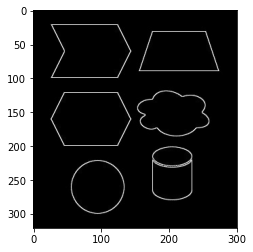

In [274]:
plt.imshow(img ^ erosian(img, structs['rect3']))

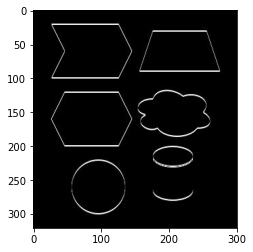

In [307]:
window = np.array([[True, False,False], [True,False,False], [True,False,False]])
plt.imshow(erosian(img, window)^dilate(img,window))

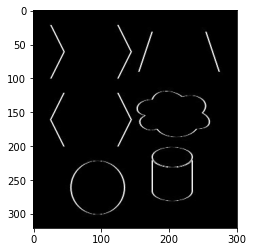

In [308]:
window = np.array([[True, True,True], [False,False,False], [False,False,False]])
plt.imshow(erosian(img, window)^dilate(img,window))